In [1]:
import fitsio
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# For the moment I'm using Pandas (based on numpy), which is a very useful tool for
# handling tables and data.
# I'll properly put them into classes or more organized later

In [2]:
#12GB file, be carefull

file_name = 'spAll-v5_10_0.fits'

In [3]:
#The resolution of the map

NSide = 2**5

In [4]:
# Columns we are interested in

fits = fitsio.FITS(file_name) #, iter_row_buffer=2000)
cols = ['RA','DEC','THING_ID','MJD','PLATE','FIBERID','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1', 'ZWARNING']

In [5]:
# to show all names in file

#fits[1]

In [6]:
%%time

# Reading columns
#http://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
d = {col: fits[1][col].read().byteswap().newbyteorder() for col in cols}

CPU times: user 21.3 s, sys: 1min 5s, total: 1min 26s
Wall time: 3min 19s


In [7]:
df = pd.DataFrame(d)
print 'number of rows =', len(df)
df.head()

number of rows = 3008000


,BOSS_TARGET1,DEC,EBOSS_TARGET0,EBOSS_TARGET1,FIBERID,MJD,PLATE,RA,THING_ID,ZWARNING
0,0,26.188042,0,2,1,57346,10000,30.012094,339167825,646
1,0,26.582945,0,1024,2,57346,10000,31.282286,342410358,0
2,0,26.608501,0,2,3,57346,10000,31.279594,342410449,4
3,0,26.682522,0,2048,4,57346,10000,31.237546,342675982,0
4,0,26.866054,0,2,5,57346,10000,31.394521,344112497,4


## Computing pixels

In [8]:
'''map celestial coordinates to angular'''
phi_rad   = lambda ra : ra*np.pi/180.
theta_rad = lambda dec: (90.0 - dec)*np.pi/180.

df['PIX'] = hp.ang2pix(NSide, theta_rad(df['DEC']), phi_rad(df['RA']))

In [9]:
df.head()

,BOSS_TARGET1,DEC,EBOSS_TARGET0,EBOSS_TARGET1,FIBERID,MJD,PLATE,RA,THING_ID,ZWARNING,PIX
0,0,26.188042,0,2,1,57346,10000,30.012094,339167825,646,3403
1,0,26.582945,0,1024,2,57346,10000,31.282286,342410358,0,3403
2,0,26.608501,0,2,3,57346,10000,31.279594,342410449,4,3403
3,0,26.682522,0,2048,4,57346,10000,31.237546,342675982,0,3403
4,0,26.866054,0,2,5,57346,10000,31.394521,344112497,4,3275


In [10]:
# Number of unique pixels

uniq_pix = df['PIX'].unique()
len(uniq_pix)

3369

## Searching for quasars

In [11]:
bit_boss = [10,11,12,13,14,15,16,17,18,19,40,41,42,43,44]
bit_eboss = [10,11,12,13,14,15,16,17,18]

def is_quasar(dataset, mask_bit):
    is_qso  = lambda b: ((df[dataset] & 2**b) > 0)
    all_qso = map(is_qso, mask_bit)
    return reduce(lambda x, y: x |  y , all_qso)

In [12]:
print 'total qso in BOSS_TARGET1 =  ', is_quasar('BOSS_TARGET1', bit_boss).sum()
print 'total qso in EBOSS_TARGET0 = ', is_quasar('EBOSS_TARGET0', bit_eboss).sum()
print 'total qso in EBOSS_TARGET1 = ', is_quasar('EBOSS_TARGET1', bit_eboss).sum() 

total qso in BOSS_TARGET1 =   466098
total qso in EBOSS_TARGET0 =  54108
total qso in EBOSS_TARGET1 =  201742


In [13]:
#Filter only quasars

only_qso = df[ is_quasar('BOSS_TARGET1', bit_boss)   |
                 is_quasar('EBOSS_TARGET0', bit_eboss) | 
                 is_quasar('EBOSS_TARGET1', bit_eboss)]
boss_qso = df[ is_quasar('BOSS_TARGET1', bit_boss)]
#only_qso.head()
print 'qsos=', len(only_qso) 
print 'boss_qsos=', len(boss_qso) 

qsos= 721948
boss_qsos= 466098


## indexing and sorting by index


In [14]:
all_qso = only_qso[only_qso['THING_ID'] != -1].set_index(['PIX','THING_ID'], drop=False).drop('PIX', 1).sort_index()

In [15]:
all_qso.head()

BOSS_TARGET1        DEC  EBOSS_TARGET0  EBOSS_TARGET1  \
PIX THING_ID                                                            
391 552894319  2199023796224  68.381197              0              0   
    552921545  2199023796224  68.418125              0              0   
392 552514273  3298535424000  68.011275              0              0   
    552514407  3298535424000  68.070896              0              0   
    552709867  2199023796224  68.289380              0              0   

               FIBERID    MJD  PLATE          RA   THING_ID  ZWARNING  
PIX THING_ID                                                           
391 552894319      622  56667   7115  175.258222  552894319         0  
    552921545      624  56667   7115  175.582630  552921545         0  
392 552514273      932  56748   6966  185.714425  552514273         0  
    552514407      886  56748   6966  185.578268  552514407         0  
    552709867      880  56748   6966  185.466450  552709867         0

In [16]:
len(all_qso)

721810

### Select  a certain pixel info

In [17]:
#only the first rows of pixel 393
all_qso.query('PIX == 450 | PIX == 796').head()

BOSS_TARGET1        DEC  EBOSS_TARGET0  EBOSS_TARGET1  \
PIX THING_ID                                                            
450 550116719  2199023255552  66.581635              0              0   
    550164118  2199023796224  66.543038              0              0   
    550164118  2199023796224  66.543038              0              0   
    550452152  2199023779840  66.701205              0              0   
    550452390  3298535424000  66.775943              0              0   

               FIBERID    MJD  PLATE          RA   THING_ID  ZWARNING  
PIX THING_ID                                                           
450 550116719      914  56720   6975  185.252205  550116719         0  
    550164118       86  56748   6966  185.340753  550164118         0  
    550164118      493  56720   7120  185.340753  550164118         0  
    550452152      976  56720   6975  185.282387  550452152         0  
    550452390       92  56748   6966  185.511519  550452390         0

In [18]:
print '# of THING_IDs within this pixel =', len(all_qso.loc[392].index)
print '# of unique THING_IDs within this pixel =', len(all_qso.loc[392].index.unique())

# of THING_IDs within this pixel = 14
# of unique THING_IDs within this pixel = 14


In [19]:
#boss_qsos = boss_qso.set_index(['PIX','THING_ID'], drop=False).drop('PIX', 1).sort_index()
#boss_qsos = only_boss_qso[only_boss_qso['THING_ID'] != -1].set_index(['PIX']).sort_index()

In [20]:
ss = all_qso.query('PIX == 450').groupby('THING_ID').size()
ss[ss>3].empty 

True

In [21]:
len(all_qso)- len(all_qso['THING_ID'].unique())

68335

In [22]:
pix_values = all_qso.index.values
len(pix_values), type(pix_values)

(721810, numpy.ndarray)

In [23]:
set_pix = set(pix_values)
list_pix= list(set_pix)

In [24]:
def pix_with_uniqueid(pix_id, max_rep):
    rep_thing_id = all_qso.query('PIX == {}'.format(pix_id)).groupby('THING_ID').size()
    if not rep_thing_id[rep_thing_id> max_rep].empty:
        print rep_thing_id[rep_thing_id> max_rep]
    

In [25]:
for i in list_pix[:200]:
    pix_with_uniqueid(i, 4)

THING_ID
341840093    5
dtype: int64
THING_ID
493044557    5
493044566    5
dtype: int64
THING_ID
492814652    5
dtype: int64
THING_ID
103525683    14
103525770    16
103526510    14
106363307    16
106364494    16
106365271    14
106366014    14
106367792    14
106368778    16
106369646    17
106370968    15
106371135    16
110624111    15
110626380    14
110626688    14
110627392    14
110627658    16
110628288    14
110628681    17
110629518    14
110629784    14
110630924    15
110630953    14
110631121    14
110632201    17
110633310    16
116045026    17
117500366    14
117587824    17
117587864    14
117727485    14
117755110    17
117770491    14
117779618    16
117793096    14
117805119    14
117819099    14
117840082    14
122364168    14
122648904    14
122667423    14
122667772    14
122668008    15
122686196    15
122714605    17
122784266    14
122784797    14
124737036     5
dtype: int64
THING_ID
461347713    5
464694423    5
dtype: int64
THING_ID
489567549    5
dtype: i

In [26]:
all_qso.query('THING_ID == 341840093')

BOSS_TARGET1        DEC  EBOSS_TARGET0  EBOSS_TARGET1  \
PIX  THING_ID                                                            
3403 341840093              0  26.479021              0           4096   
     341840093  3298535424000  26.479021              0              0   
     341840093  3298535424000  26.479021              0              0   
     341840093              0  26.479021              0           4096   
     341840093              0  26.479021              0           4096   

                FIBERID    MJD  PLATE        RA   THING_ID  ZWARNING  
PIX  THING_ID                                                         
3403 341840093       92  57346  10000  30.48258  341840093         0  
     341840093      990  55944   5697  30.48258  341840093         0  
     341840093      202  56273   6270  30.48258  341840093         0  
     341840093      100  57040   7691  30.48258  341840093         0  
     341840093       94  57360   7691  30.48258  341840093         0

In [68]:
%ls

BOSS_dr12_qso.fits               sdss_catalog.ipynb
DR12Q.fits                       spAll-v5_10_0.fits
DR12Q.ipynb                      spec-5697-55944-0990.fits
README.md                        spec-6270-56273-0220.fits
findQuasars_test.ipynb           wmap_band_imap_r9_7yr_W_v4.fits
py/


In [345]:
files_1= 'spec-5697-55944-0990.fits'
files_2= 'spec-6270-56273-0220.fits'
files_3= 'spec-7691-57040-0100.fits'
files_4= 'spec-7691-57360-0094.fits'
files_5= 'spec-10000-57346-0092.fits'
fits = fitsio.FITS(files_2)
fits[0].read_header() #['COEFF0']



SIMPLE  =                    T / conforms to FITS standard
BITPIX  =                    8 / array data type
NAXIS   =                    0 / number of array dimensions
EXTEND  =                    T
TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey
FLAVOR  = 'science '           / exposure type, SDSS spectro style
BOSSVER = '2       '           / ICC version
MJD     =                56273 / APO fMJD day at start of exposure
MJDLIST = '56272 56273'        /
NAME    = '6270-56271-01'      / The name of the currently loaded plate
PLATEID =                 6270 / The currently loaded plate
TILEID  =                15216 /Cartridge used in this plugging
CARTID  =                   17 /Cartridge used in this plugging
MAPID   =                    1 / The mapping version of the loaded plate
RA      =            30.274498 / RA of telescope boresight (deg)
DEC     =            27.759549 / Dec of telescope boresight (deg)
EQUINOX =              2000.00 /
RADECSYS= 'FK5     '           /


In [251]:
def read_flux(files):
    fits = fitsio.FITS(files)
    cols = ['flux','loglam','ivar','and_mask','or_mask', 'sky', 'wdisp', 'model']
    d = {col: fits[1][col].read().byteswap().newbyteorder() for col in cols}
    df = pd.DataFrame(d)
    return df

In [252]:
files =(files_1, files_2, files_3, files_4, files_5)
dt_s=[]
for l in files:
        dt_x = read_flux(l).set_index('loglam')
        dt_s.append(dt_x)

In [261]:
# Masking
mask=[]
for s in dt_s:
    mask.append(s.query('and_mask==0 & or_mask==0').copy())

In [262]:
mask[1].head()

,and_mask,flux,ivar,model,or_mask,sky,wdisp
loglam,,,,,,,
3.5516,0,-4.858162,0.054479,0.256338,0,4.565974,1.340524
3.5517,0,-0.145810,0.050717,0.259966,0,4.341277,1.332116
3.5518,0,9.137352,0.057707,0.263985,0,3.994678,1.335651
3.5519,0,-4.428214,0.057576,0.269347,0,3.797942,1.334435
3.5520,0,19.445345,0.051647,0.271861,0,3.649121,1.331097


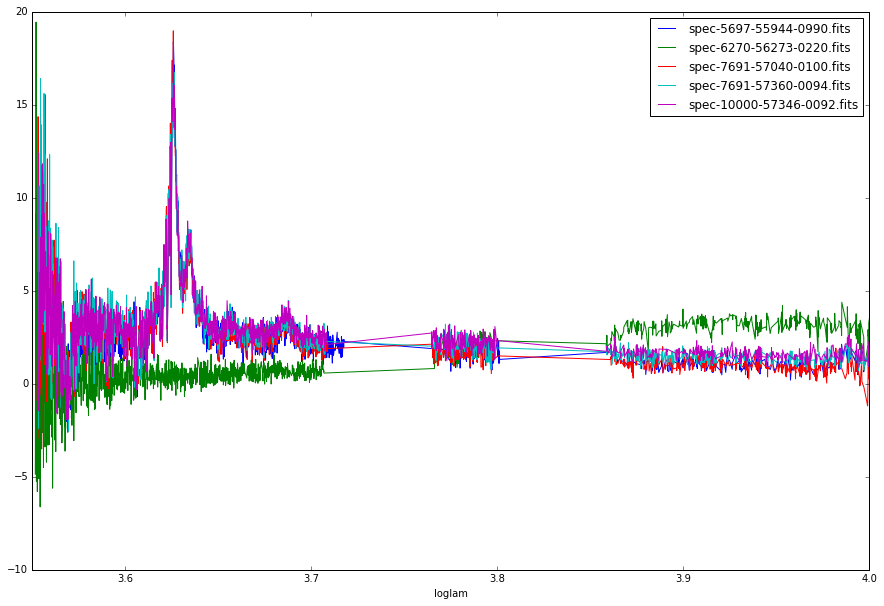

In [264]:
fig = plt.figure(figsize = (15, 10))
xlimits = [3.55,4]
ylimits = [-10,20]
for i in range(4):
    mask[i]['flux'].plot(label=files[i])
mask[4]['flux'].plot(xlim=xlimits, ylim=ylimits, label=files_5) 
plt.legend(loc='best')

In [327]:
#print [len(mask[i]) for i in range(5)]
#for i in range(5):
#    print (mask[i].index.values.min()- mask[i].index.values.max())/len(mask[i])
for i in range(5):
    x=dt_s[i].index.values
    
    print (x[-1]-x[0])/(len(x)-1)

0.000100000007618
9.99999540885e-05
0.000100000050708
0.000100000007618
9.99999781355e-05


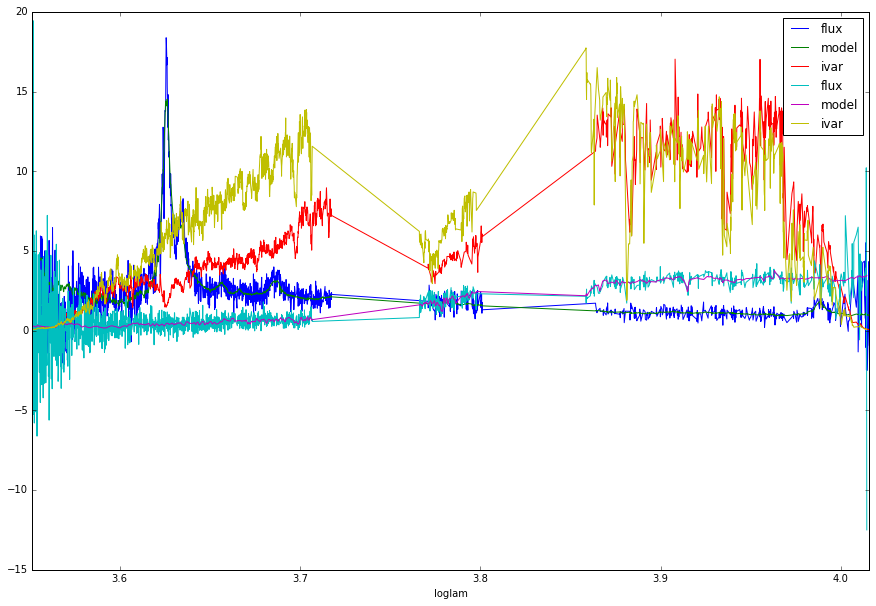

In [308]:
fig = plt.figure(figsize = (15, 10))
ax= plt.subplot(1,1,1)
#dt_s
mask[0][['flux','model', 'ivar']].plot(ax=ax)
mask[1][['flux','model', 'ivar']].plot(ax=ax)